In [ ]:
%matplotlib inline
# ------------------
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# ------------------
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from os.path import join
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose.data import epfl_campus
from mvpose import pose
import paf_loader

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

from mvpose.algorithm import settings

# =========================================================

from mvpose.evaluation import pcp
#import mvpose.data.kth_football2 as kth
#import mvpose.data.skeleton_augmentation as ska
#model_path = '../data/model_poseprediction.h5'
#gen = ska.LimbGenerator(model_path, params.scale_to_mm)

def generate_pcp_score(candidates, Y):
    Humans = kth.transform3d_from_mscoco(candidates)
    
    #Im, Y, Calib = epfl_campus.get(root, frame)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    Avg = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            alpha = 0.5
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        Avg.append(avg)
        GTIDs.append(gtid)
    
    del candidates
    
    return L_Arms, U_Arms, L_Legs, U_Legs, Avg, GTIDs

# =========================================================

hm_detection_threshold = 0.1
max_epi_distance = 10
gc_radius = 0
gc_max_radius = 300
min_nbr_joints = 7
min_symmetric_distance = 500
settings_campus = settings.get_settings(scale_to_mm=1000,
                                        min_symmetric_distance=min_symmetric_distance,
                                        gc_radius=gc_radius,
                                        min_nbr_joints=min_nbr_joints,
                                        gc_max_radius=gc_max_radius,
                                        max_epi_distance=max_epi_distance,
                                       hm_detection_threshold=hm_detection_threshold)

#FRAMES_campus = [351, 352, 353, 354, 355, 356, 357, 358, 669, 670, 671, 672, 680, 690, 691, 692, 693]
#FRAMES_kth = [10, 20, 30, 40, 50, 60, 70, 100, 150]
#FRAMES_campus = [351, 352]
# FRAMES_campus = [400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
#                  410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
#                  680, 681, 682, 683, 684, 685, 686, 687, 688, 689,
#                  690, 691, 692, 693, 694, 696, 697, 698, 699, 700,
#                  701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
#                  711, 712, 713, 714, 715, 716, 717, 718, 719, 720,
#                  721, 722, 723, 724, 725, 726, 727, 728, 729, 730]
FRAMES_campus = [400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
                 721, 722, 723, 724, 725, 726, 727, 728, 729, 730]


def calc_frame(f):
    print('starting frame ', f)
    _start = time()
    Im, Y, Calib = epfl_campus.get(root, f)
    heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
        'campus', Im, f, dir=tmp)

    #detections = pose.estimate_heuristic(
    detections = pose.estimate_heuristic(
        Calib, heatmaps, pafs, settings=settings_campus, 
        debug=False)
    _end = time()
    del Im
    del Calib
    del heatmaps 
    del pafs
    print('\telapsed', _end - _start)
    return detections, Y 
    

# for f in FRAMES_campus:
#     calc_frame(f)

def run_all():
    PER_GTID = {}
    for idx, frame in enumerate(FRAMES_campus):
        detections, Y = calc_frame(frame)
        L_Arms, U_Arms, L_Legs, U_Legs, Avg, GTIDs =\
            generate_pcp_score(detections, Y)

        if len(L_Arms) > 0:
            for gtid, larms, uarms, llegs, ulegs, avg in zip(
                GTIDs, L_Arms, U_Arms, L_Legs, U_Legs, Avg
            ):
                if not gtid in PER_GTID:
                    PER_GTID[gtid] = {
                        'larms': [],
                        'uarms': [],
                        'llegs': [],
                        'ulegs': [],
                        'avg': [],
                        'frame': []
                    }
                PER_GTID[gtid]['larms'].append(larms)
                PER_GTID[gtid]['uarms'].append(uarms)
                PER_GTID[gtid]['llegs'].append(llegs)
                PER_GTID[gtid]['ulegs'].append(ulegs)
                PER_GTID[gtid]['avg'].append(avg)
                PER_GTID[gtid]['frame'].append(frame)
        del detections
        del Y
        del L_Arms
        del U_Arms
        del L_Legs
        del U_Legs
        del Avg
        del GTIDs
    
    for gtid, data in PER_GTID.items():
        print("hid:", gtid)
        print('larms:\t', np.mean(PER_GTID[gtid]['larms']))
        print('uarms:\t', np.mean(PER_GTID[gtid]['uarms']))
        print('llegs:\t', np.mean(PER_GTID[gtid]['llegs']))
        print('ulegs:\t', np.mean(PER_GTID[gtid]['ulegs']))
        print('avg:\t', np.mean(PER_GTID[gtid]['avg']))
    

run_all()

# Experiments

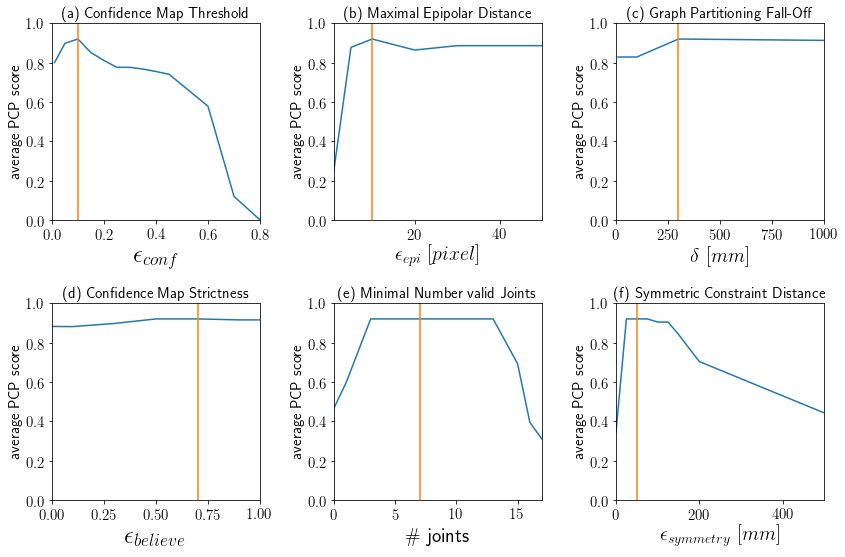

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 15})

W = 3
H = 2
FS = 15

fig = plt.figure(figsize=(12, 8))

# heatmap detection threshold
VALUES_EXP_1 = {
    '0.01': {
        'larms' :[0.725, 0.9, 0.9],
        'uarms' : [0.9, 1, 0.7],
        'llegs' : [0.9, 1, 0.7],
        'ulegs' : [0.9, 1, 0.7],
        'avg' : [0.856, 0.8958, 0.65]
    },
    '0.05': {
        'larms' :[0.825, 0.5, 0.8],
        'uarms' : [1, 0.888, 1],
        'llegs' : [1, 0.888, 1],
        'ulegs' : [1, 0.888, 1],
        'avg' : [0.956, 0.79, 0.95]
    },
    '0.1': {
        'larms' :[0.775, 0.55, 0.75],
        'uarms' : [1, 0.95, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    },
    '0.15': {
        'larms' :[0.725, 0.36, 0.75],
        'uarms' : [1, 0.666, 0.95],
        'llegs' : [1, 0.888, 1],
        'ulegs' : [1, 0.888, 1],
        'avg' : [0.93, 0.7, 0.925]
    },
    '0.2': {
        'larms' :[0.6, 0.388, 0.4],
        'uarms' : [1, 0.611, 0.85],
        'llegs' : [1, 0.944, 1],
        'ulegs' : [1, 0.944, 1],
        'avg' : [0.9, 0.722, 0.8125]
    },
    '0.25': {
        'larms' :[0.475, 0.3888, 0.3],
        'uarms' : [1, 0.555, 0.6],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.869, 0.736, 0.725]
    },
    '0.3': {
        'larms' :[0.475, 0.3888, 0.3],
        'uarms' : [1, 0.555, 0.6],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.869, 0.736, 0.725]
    },
    '0.35': {
        'larms' :[0.45, 0.36, 0.3],
        'uarms' : [1, 0.555, 0.55],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.8625, 0.729, 0.7125]
    },
    '0.4': {
        'larms' :[0.425, 0.2777, 0.3],
        'uarms' : [1, 0.555, 0.5],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.856, 0.71, 0.7]
    },
    '0.45': {
        'larms' :[0.375, 0.19444, 0.3],
        'uarms' : [1, 0.5277, 0.5],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.84375, 0.681, 0.7]
    },
    '0.6': {
        'larms' :[0.25, 0, 0.15],
        'uarms' : [0.875, 0.1388, 0.45],
        'llegs' : [0.875, 0.75, 0.9],
        'ulegs' : [0.875, 0.777, 0.9],
        'avg' : [0.719, 0.4166, 0.6]
    },
    '0.7': {
        'larms' :[0.075, 0, 0],
        'uarms' : [0.45, 0, 0],
        'llegs' : [0.4, 0.0555, 0],
        'ulegs' : [0.4, 0.0555, 0],
        'avg' : [0.33, 0.0277, 0]
    }, 
    '0.8': {
        'larms' :[0, 0, 0],
        'uarms' : [0, 0, 0],
        'llegs' : [0, 0, 0],
        'ulegs' : [0, 0, 0],
        'avg' : [0, 0, 0]
    },
}

x = [float(k) for k in VALUES_EXP_1.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_1.items()]

ax = fig.add_subplot(H, W, 1)
ax.set_title('(a) Confidence Map Threshold', fontsize=FS)
ax.plot(x, y)
ax.set_xlim([0, 0.8])
ax.set_ylim([0, 1])
ax.plot([0.1, 0.1], [0, 1])
ax.set_xlabel(r'$\epsilon_{conf}$', fontsize=FS+10)
ax.set_ylabel('average PCP score', fontsize=FS)

# ===================================================
# EXPERIMENT 2
# maximal epipolar distance
# ===================================================
# heatmap detection threshold


VALUES_EXP_2 = {
    '1': {
        'larms' :[0.025, 0.0277, 0.05],
        'uarms' : [0.4, 0.1666, 0.35],
        'llegs' : [0.4, 0.1944, 0.25],
        'ulegs' : [0.575, 0.2777, 0.35],
        'avg' : [0.35, 0.1666, 0.25]
    },
    '5': {
        'larms' :[0.6, 0.5, 0.65],
        'uarms' : [1, 0.9444, 0.95],
        'llegs' : [0.95, 1, 1],
        'ulegs' : [0.95, 1, 1],
        'avg' : [0.875, 0.86, 0.9]
    },
    '10': {
        'larms' :[0.775, 0.55, 0.75],
        'uarms' : [1, 0.95, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    },
    '20': {
        'larms' :[0.775, 0.4722, 0.75],
        'uarms' : [1, 0.8333, 0.95],
        'llegs' : [1, 0.8055, 1],
        'ulegs' : [1, 0.8055, 1],
        'avg' : [0.94, 0.729, 0.925]
    }, 
    '30': {
        'larms' :[0.825, 0.555, 0.75],
        'uarms' : [1, 0.9166, 0.95],
        'llegs' : [1, 0.8333, 1],
        'ulegs' : [1, 0.8333, 1],
        'avg' : [0.956, 0.78, 0.925]
    }, 
    '50': {
        'larms' :[0.825, 0.555, 0.75],
        'uarms' : [1, 0.9166, 0.95],
        'llegs' : [1, 0.8333, 1],
        'ulegs' : [1, 0.8333, 1],
        'avg' : [0.956, 0.78, 0.925]
    }
}
    
ax = fig.add_subplot(H, W, 2)

x = [float(k) for k in VALUES_EXP_2.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_2.items()]
ax.plot(x, y)
ax.plot([10, 10], [0, 1])
ax.set_xlim([1, 50])
ax.set_ylim([0, 1])

ax.set_xlabel(r'$\epsilon_{epi} \ [pixel]$', fontsize=FS+5)
ax.set_ylabel('average PCP score', fontsize=FS)
ax.set_title('(b) Maximal Epipolar Distance', fontsize=FS)

# ===================================================
# EXPERIMENT 3
# graphcut radius
# ===================================================


VALUES_EXP_3 = {
    '10': {
        'larms' :[0.725, 0.555, 0.35],
        'uarms' : [0.875, 0.9444, 0.75],
        'llegs' : [0.95, 1, 0.9],
        'ulegs' : [0.8875, 1, 0.9],
        'avg' : [0.8875, 0.875, 0.725]
    },
    '100': {
        'larms' :[0.725, 0.555, 0.35],
        'uarms' : [0.875, 0.9444, 0.75],
        'llegs' : [0.95, 1, 0.9],
        'ulegs' : [0.8875, 1, 0.9],
        'avg' : [0.8875, 0.875, 0.725]
    },
    '300': {
        'larms' :[0.775, 0.55, 0.75],
        'uarms' : [1, 0.95, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    },
    '1000': {
        'larms' :[0.875, 0.5, 0.75],
        'uarms' : [1, 0.92, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.854, 0.925]
    }
}


ax = fig.add_subplot(H, W, 3)

x = [float(k) for k in VALUES_EXP_3.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_3.items()]
ax.plot(x, y)
ax.plot([300, 300], [0, 1])
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1])

ax.set_xlabel(r'$\delta \ [mm]$', fontsize=FS+5)
ax.set_ylabel('average PCP score', fontsize=FS)
ax.set_title('(c) Graph Partitioning Fall-Off', fontsize=FS)

# ===================================================
# EXPERIMENT 4
# graphcut radius
# ===================================================

VALUES_EXP_4 = {
    '0': {
        'larms' :[0.8, 0.47, 0.7],
        'uarms' : [1, 0.666, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.95, 0.785, 0.9125]
    },
    '0.1': {
        'larms' :[0.875, 0.4166, 0.764],
        'uarms' : [1, 0.6388, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9687, 0.76388, 0.9125]
    },
    '0.3': {
        'larms' :[0.85, 0.5, 0.75],
        'uarms' : [1, 0.722, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.8055, 0.925]
    },
    '0.5': {
        'larms' :[0.85, 0.55, 0.75],
        'uarms' : [1, 0.944, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    },
    '0.7': {
        'larms' :[0.85, 0.55, 0.75],
        'uarms' : [1, 0.944, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    },
    '0.9': {
        'larms' :[0.85, 0.5277, 0.75],
        'uarms' : [1, 0.9166, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.86, 0.925]
    },
    '1': {
        'larms' :[0.85, 0.5277, 0.75],
        'uarms' : [1, 0.9166, 0.95],
        'llegs' : [1, 1, 1],
        'ulegs' : [1, 1, 1],
        'avg' : [0.9625, 0.86, 0.925]
    }
}


ax = fig.add_subplot(H, W, 4)

x = [float(k) for k in VALUES_EXP_4.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_4.items()]
ax.plot(x, y)
ax.plot([0.7, 0.7], [0, 1])
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.set_xlabel(r'$\epsilon_{believe}$', fontsize=FS+10)
ax.set_ylabel('average PCP score', fontsize=FS)
ax.set_title('(d) Confidence Map Strictness', fontsize=FS)


# ===================================================
# EXPERIMENT 5
# min number joints
# ===================================================

VALUES_EXP_5 = {
    '0': {
        'larms' : [0.5,    0, 0.75],
        'uarms' : [0.55,   0, 0.9],
        'llegs' : [0.55,   0, 0.9],
        'ulegs' : [0.55,   0, 0.9],
        'avg' :   [0.5375, 0, 0.8625]
    },
    '1': {
        'larms' :[0.65, 0.47, 0.3],
        'uarms' : [0.7, 0.777, 0.4],
        'llegs' : [0.7, 0.833, 0.4],
        'ulegs' : [0.7, 0.833, 0.4],
        'avg' : [0.6875, 0.729, 0.375]
    }, 
    '3': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '5': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '7': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '9': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '11': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '13': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.4],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '15': {
        'larms' :[0.425, 0.5, 0.75],
        'uarms' : [0.45 , 0.777, 0.95],
        'llegs' : [0.45 , 0.777, 1],
        'ulegs' : [0.45 , 0.777, 1],
        'avg' : [0.44375, 0.708, 0.925]
    },
    '16': {
        'larms' : [0, 0.194, 0.75],
        'uarms' : [0, 0.277, 0.95],
        'llegs' : [0, 0.277, 1],
        'ulegs' : [0, 0.277, 1],
        'avg' :   [0, 0.257, 0.925]
    },
    '17': {
        'larms' : [0, 0, 0.75],
        'uarms' : [0, 0, 0.95],
        'llegs' : [0, 0, 1],
        'ulegs' : [0, 0, 1],
        'avg' :   [0, 0, 0.925]
    }
}


ax = fig.add_subplot(H, W, 5)

x = [float(k) for k in VALUES_EXP_5.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_5.items()]
ax.plot(x, y)
ax.plot([7, 7], [0, 1])
ax.set_xlim([0, 17])
ax.set_ylim([0, 1])

ax.set_xlabel('\# joints', fontsize=FS+5)
ax.set_ylabel('average PCP score', fontsize=FS)
ax.set_title('(e) Minimal Number valid Joints', fontsize=FS)

# ===================================================
# EXPERIMENT 6
# symm joints
# ===================================================
    
VALUES_EXP_6 = {
    '0': {
        'larms' : [0.15, 0.1388, 0.25],
        'uarms' : [0.35,   0.33, 0.45],
        'llegs' : [0.35, 0.3888, 0.5],
        'ulegs' : [0.35, 0.3888, 0.5],
        'avg' :   [0.3,  0.3125, 0.425]
    },
    '25': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.95],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '50': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.95],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '75': {
        'larms' :[0.85, 0.555, 0.75],
        'uarms' : [1 , 0.944, 0.95],
        'llegs' : [1 , 1, 1],
        'ulegs' : [1 , 1, 1],
        'avg' : [0.9625, 0.875, 0.925]
    }, 
    '100': {
        'larms' :[0.825,  0.555, 0.75],
        'uarms' : [1 ,    0.944,   0.95],
        'llegs' : [0.975, 0.916,   1],
        'ulegs' : [0.975,     1,   1],
        'avg' : [0.94,     0.85, 0.925]
    }, 
    '125': {
        'larms' :[0.825,  0.555, 0.75],
        'uarms' : [1 ,    0.944,   0.95],
        'llegs' : [0.975, 0.916,   1],
        'ulegs' : [0.975,     1,   1],
        'avg' : [0.94,     0.85, 0.925]
    }, 
    '150': {
        'larms' :[0.85,  0.555, 0.7],
        'uarms' : [1 ,    0.944,   0.95],
        'llegs' : [0.5,   0.833,   0.9],
        'ulegs' : [0.8,   0.888,   0.9],
        'avg' : [0.86,    0.805, 0.8625]
    }, 
    '200': {
        'larms' :[0.85,  0.555, 0.7],
        'uarms' : [1 ,    0.944,   0.9],
        'llegs' : [0.5,   0.583,   0.65],
        'ulegs' : [0.5,   0.611,   0.65],
        'avg' : [0.7125,    0.674, 0.725]
    }, 
    '500': {
        'larms' :[0.4,  0.3888, 0.3],
        'uarms' : [0.475 ,  0.5,   0.45],
        'llegs' : [0.45,   0.4722,   0.45],
        'ulegs' : [0.475,   0.5,   0.45],
        'avg' : [0.45,    0.465, 0.4125]
    }
}

    
ax = fig.add_subplot(H, W, 6)

x = [float(k) for k in VALUES_EXP_6.keys()]
y = [np.mean(v['avg']) for (_, v) in VALUES_EXP_6.items()]
ax.plot(x, y)
ax.plot([50, 50], [0, 1])
ax.set_xlim([0, 500])
ax.set_ylim([0, 1])

ax.set_xlabel(r'$\epsilon_{symmetry} \ [mm]$', fontsize=FS+5)
ax.set_ylabel('average PCP score', fontsize=FS)
ax.set_title('(f) Symmetric Constraint Distance', fontsize=FS)

plt.tight_layout()

plt.savefig('exp_parameters.eps', format='eps', dpi=300)
#plt.show()